# Differential Equations as a Pytorch Neural Network Layer

> How to use differential equations layers in pytorch

Differential equations have formed the mathematical basis for much of modern science as they allow us to specify a model for how a system evolves in time and solve for the state of the system at any time. Physical laws, such as Newton's laws of motion, are differential equations. In biology differential equation models have been used to describe the dynamics of gene expression, cell division, and neurons firing. These models are still an essential tool in science and engineering. 

The deep learning revolution has brought with it a new set of tools for performing large scale optimizations over enormous datasets. In this post I will show how you can hijack these tools to determine the parameters of a differential equation model from data efficiently. I will use the most popular deep learning framework, pytorch, to do this. 


## What is the problem we are trying to solve? 

Let's say we have some time series data $y(t)$ that we want to model with a differential equation. The data takes the form of a set of observations $y_i$ at times $t_i$. Based on some knowledge of the underlying system we can write down a differential equation that we think describes the system. In the most general form this takes the form:

\begin{align}
& \frac{dy}{dt} = f(y,t;\theta) \nonumber \\
& y(t_0) = y_0 \nonumber
\end{align}

where $y$ is the state of the system, $t$ is time, and $\theta$ are the parameters of the model. In this post we will assume that the parameters $\theta$ are unknown and we want to learn them from the data. 

Insert a gif here to keep them motivated.....

In [1]:
#| default_exp training

In [2]:
#| hide 
%load_ext autoreload
%autoreload 2

Let's import the libraries we will need for this post. The only non standard machine learning library we will use the torchdiffeq library to solve the differential equations. This library implements numerical differential equation solvers in pytorch. 

In [1]:
#| export 

import torch 
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint
import pylab as plt
from torch.utils.data import Dataset, DataLoader
from typing import Callable, List, Tuple, Union, Optional

One thing to note is that we can use gpu acceleration to solve the differential equations if that is available on our system. This code is a common trick for checking this and choosing the appropriate device.

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Models

The first step of our modeling process is to define the model. For differential equations this means we choose a form for the function $f(y,t;\theta)$ and a way to represent the parameters $\theta$. We also need to do this in a way that is compatible with pytorch. This means we need to encode our function as a torch.nn.Module class. This is a pytorch class that allows you to define a model as a series of layers. The model is defined in the `__init__` function and the forward pass is defined in the `forward` function. The forward pass is the function that is called when you call the model on some input data.

### VDP Oscillator

We can define a differential equation system using the `torch.nn.Module` class where the parameters are created using the `torch.nn.Parameter` 
declaration. This lets pytorch know that we want to accumulate gradients for those parameters. We can also include fixed parameters (don't want to fit these) by just not wrapping them with this declaration. 

The classic VDP oscillator is a nonlinear oscillator with a single parameter $\mu$. The differential equation for this system is:

\begin{align}
\frac{dX}{dt} &= \mu(x-\frac{1}{3}x^3-y) \nonumber \\
\frac{dY}{dt} &= \frac{x}{\mu} \nonumber \\
\end{align}

where $X$ and $Y$ are the state variables. We can define this system in pytorch as follows:


In [3]:
#| exports 

class VDP(nn.Module):
    """ 
    Define the Van der Pol oscillator as a PyTorch module.
    """
    def __init__(self, 
                 mu: float, # Stiffness parameter of the VDP oscillator
                 ):
        super().__init__() 
        self.mu = torch.nn.Parameter(torch.tensor(mu)) # make mu a learnable parameter
        
    def forward(self, 
                t: float, # time index
                state: torch.TensorType, # state of the system first dimension is the batch size
                ) -> torch.Tensor: # return the derivative of the state
        """ 
            Define the right hand side of the VDP oscillator.
        """
        x = state[:, 0] # first dimension is the batch size
        y = state[:, 1]
        dX = self.mu*(x-1/3*x**3 - y)
        dY = 1/self.mu*x
        dfunc = torch.zeros_like(state) # trick to make sure our ret
        dfunc[:, 0] = dX
        dfunc[:, 1] = dY
        return dfunc
    
    def __repr__(self):
        """Print the parameters of the model."""
        return f" mu: {self.mu.item()}"
    
    

Let's see how we can integrate this model using torchdiffeq methods and make a plot of the solution. 

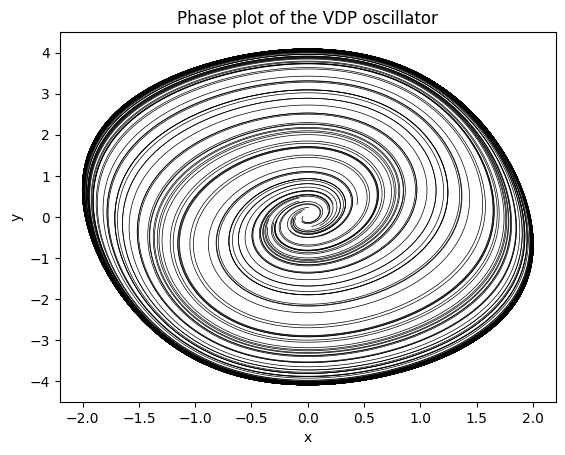

In [10]:
vdp_model = VDP(mu=0.5)

# Create a time vector, this is the time axis of the ODE
ts = torch.linspace(0,30.0,1000)
# Create a batch of initial conditions 
batch_size = 30
# Creates some random initial conditions
initial_conditions = torch.tensor([0.01, 0.01]) + 0.2*torch.randn((batch_size,2))

# Solve the ODE, odeint comes from torchdiffeq
sol = odeint(vdp_model, initial_conditions, ts, method='dopri5').detach().numpy()

# Check the solution
plt.plot(sol[:,:,0], sol[:,:,1], color='black', lw=0.5);
plt.title("Phase plot of the VDP oscillator");
plt.xlabel("x");
plt.ylabel("y");


The solution comes back as a torch tensor with dimensions (time_points, batch number, dynamical_dimension). 

In [44]:
sol.shape

(1000, 30, 2)

### Lotka Volterra Predator Prey equations 

As another example we create a module for the predator-prey equations.

In [ ]:
#| exports


class LotkaVolterra(nn.Module):
    """ 
     The Lotka-Volterra equations are a pair of first-order, non-linear, differential equations
     describing the dynamics of two species interacting in a predator-prey relationship.
    """
    def __init__(self,
                 alpha: float = 1.5, # The alpha parameter of the Lotka-Volterra system
                 beta: float = 1.0, # The beta parameter of the Lotka-Volterra system
                 delta: float = 3.0, # The delta parameter of the Lotka-Volterra system
                 gamma: float = 1.0 # The gamma parameter of the Lotka-Volterra system
                 ) -> None:
        super().__init__()
        self.model_params = torch.nn.Parameter(torch.tensor([alpha, beta, delta, gamma]))
        
        
    def forward(self, t, state):
        x = state[:,0]      #variables are part of vector array u 
        y = state[:,1]
        sol = torch.zeros_like(state)
        
        alpha, beta, delta, gamma = self.model_params    #coefficients are part of vector array p
        sol[:,0] = alpha*x - beta*x*y
        sol[:,1] = -delta*y + gamma*x*y
        return sol
    
    def __repr__(self):
        return f" alpha: {self.model_params[0].item()}, beta: {self.model_params[1].item()}, delta: {self.model_params[2].item()}, gamma: {self.model_params[3].item()}"


Integrate and make the same plots as the other systems

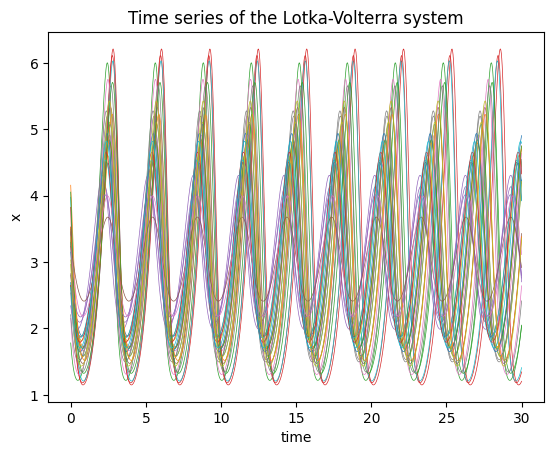

In [ ]:
lv_model = LotkaVolterra()
ts = torch.linspace(0,30.0,1000)
# Create a batch of initial conditions (batch_dim, state_dim) as small perturbations around one value
initial_conditions = torch.tensor([[3,3]]) + 0.50*torch.randn((30,2))
sol = odeint(lv_model, initial_conditions, ts, method='dopri5').detach().numpy()
# Check the solution

plt.plot(ts, sol[:,:,0], lw=0.5);
plt.title("Time series of the Lotka-Volterra system");
plt.xlabel("time");
plt.ylabel("x");

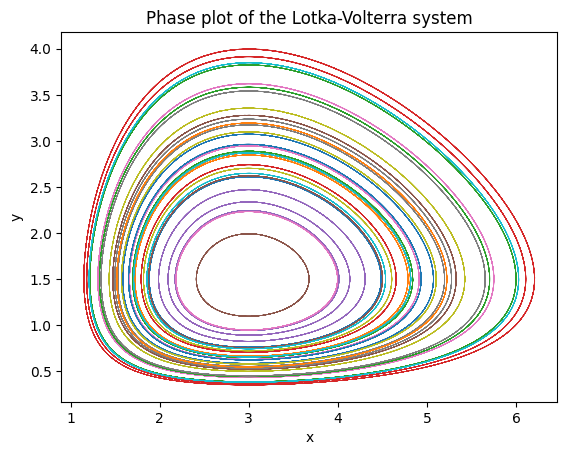

In [ ]:
plt.plot(sol[:,:,0], sol[:,:,1], lw=0.5);
plt.title("Phase plot of the Lotka-Volterra system");
plt.xlabel("x");
plt.ylabel("y");

### Lorenz system 

This defines a the famous Lorenz differential equations which give chaotic dynamics for the default parameter values
as shown. 

In [4]:
#| exports

class Lorenz(nn.Module):
    """ 
    Define the Lorenz system as a PyTorch module.
    """
    def __init__(self, 
                 sigma: float =10.0, # The sigma parameter of the Lorenz system
                 rho: float=28.0, # The rho parameter of the Lorenz system
                beta: float=8.0/3, # The beta parameter of the Lorenz system
                ):
        super().__init__() 
        self.model_params = torch.nn.Parameter(torch.tensor([sigma, rho, beta]))
        
        
    def forward(self, t, state):
        x = state[:,0]      #variables are part of vector array u 
        y = state[:,1]
        z = state[:,2]
        sol = torch.zeros_like(state)
        
        sigma, rho, beta = self.model_params    #coefficients are part of vector array p
        sol[:,0] = sigma*(y-x)
        sol[:,1] = x*(rho-z) - y
        sol[:,2] = x*y - beta*z
        return sol
    
    def __repr__(self):
        return f" sigma: {self.model_params[0].item()}, rho: {self.model_params[1].item()}, beta: {self.model_params[2].item()}"
    

This shows how to integrate this system and plot the results. You can see that close iniial conditions end up very far apart later in time

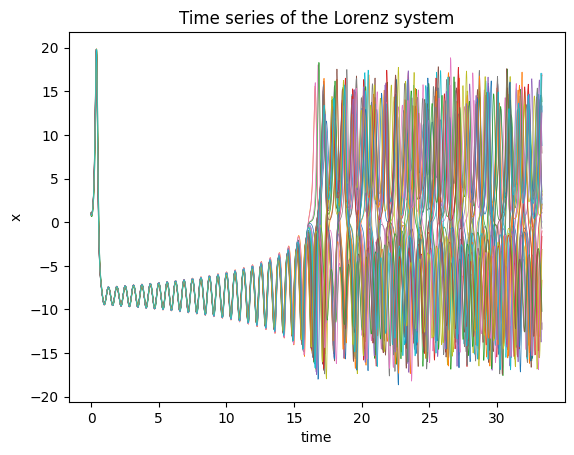

In [5]:
lorenz_model = Lorenz()
ts = torch.linspace(0,50.0,3000)
# Create a batch of initial conditions (batch_dim, state_dim) as small perturbations around one value
initial_conditions = torch.tensor([[1.0,0.0,0.0]]) + 0.10*torch.randn((30,3))
sol = odeint(lorenz_model, initial_conditions, ts, method='dopri5').detach().numpy()
# Check the solution

plt.plot(ts[:2000], sol[:2000,:,0], lw=0.5);
plt.title("Time series of the Lorenz system");
plt.xlabel("time");
plt.ylabel("x");

Here we show the famous butterfly plot for the first set of initial conditions in the batch. 

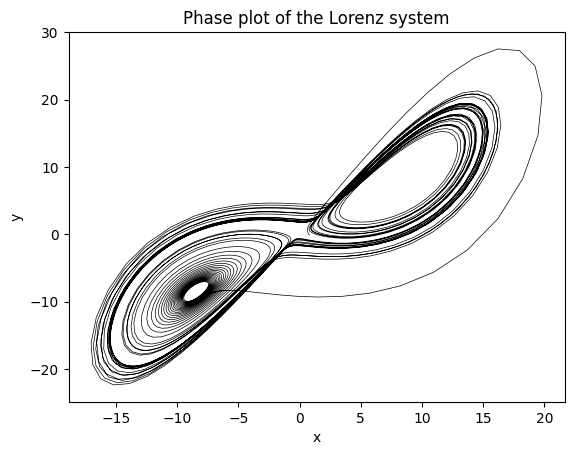

In [6]:
plt.plot(sol[:,0,0], sol[:,0,1], color='black', lw=0.5);
plt.title("Phase plot of the Lorenz system");
plt.xlabel("x");
plt.ylabel("y");

## Data

Now that we can define the models we need to create some data to train on. Here I use the pytorch `Dataset` class to create create some simulated datasets for our models. Really we could just use tensor of data directly, but this is a nice way to organize the data. It will also be useful if you have some experimental data that you want to use. For a torch `Dataset` you need to define a `__len__` function that returns the number of data points and a `__getitem__` function that returns the data point at a given index. The rest of boilerplate code needed in defined in the parent class `torch.utils.data.Dataset`. 

In [18]:
#| exports 

class SimODEData(Dataset):
    """ 
        A very simple dataset class for simulating ODEs
    """
    def __init__(self,
                 ts: List[torch.Tensor], # List of time points as tensors
                 values: List[torch.Tensor], # List of dynamical state values (tensor) at each time point 
                 ) -> None:
        self.ts = ts 
        self.values = values 
        
    def __len__(self) -> int:
        return len(self.ts)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.ts[index], self.values[index]

      

Next let's create a quick generator function to generate some simulated data to test the algorithms on. In a real use case the data would be loaded from a file or database, but for this example we will just generate some data. In fact, I recommend that you always start with generated data to make sure your code is working before you try to load real data. 

In [19]:

#| export 

def create_sim_dataset(model: nn.Module, # model to simulate from
                       ts: torch.Tensor, # Time points to simulate at
                       num_samples: int = 10, # Number of samples to generate
                       sigma_noise: float = 0.1, # Noise level to add to the data
                       initial_conditions_default: torch.Tensor = torch.tensor([0.0, 0.0]), # Default initial conditions
                       sigma_initial_conditions: float = 0.1, # Noise level to add to the initial conditions
                       ) -> SimODEData:
    ts_list = [] 
    states_list = [] 
    dim = initial_conditions_default.shape[0]
    for i in range(num_samples):
        x0 = sigma_initial_conditions * torch.randn((1,dim)).detach() + initial_conditions_default
        ys = odeint(model, x0, ts).squeeze(1).detach() 
        ys += sigma_noise*torch.randn_like(ys)
        ts_list.append(ts)
        states_list.append(ys)
    return SimODEData(ts_list, states_list)
    


Next we will create a wrapper function for a pytorch training loop. As a brief review the training loop consists of the following steps:

* Divide the dataset into mini-batches
* Iterate through the mini-batches, for each mini-batch:
    * Generate the predictions using the current model parameters
    * Calculate the loss (here we will use the mean squared error)
    * Calculate the gradients, using automatic differentiation. 
    * Update the parameters using a gradient descent step. Here we use the Adam optimizer.
* Each full pass through the dataset is called an epoch. 
  


In [20]:

#| exports

def train(model: torch.nn.Module, # Model to train
          data: SimODEData, # Data to train on
          lr: float = 1e-2, # learning rate for the Adam optimizer
          epochs: int = 10, # Number of epochs to train for
          batch_size: int = 5, # Batch size for training
          ):
    
    trainloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(epochs):
        running_loss = 0.0 
        for data in trainloader:
            optimizer.zero_grad() # reset gradients
            ts, states = data 
            initial_state = states[:,0,:] # grab the initial state
            pred = odeint(model, initial_state, ts[0]).transpose(0,1)
            loss = criterion(pred, states)
            loss.backward() # compute gradients
            optimizer.step() # update parameters
            running_loss += loss.item() # record loss
        if epoch % 10 == 0:
            print(f"Loss at {epoch}: {running_loss}")



## Examples

### Fitting the VDP Oscillator

Let's use this training loop to recover the parameters from simulated VDP oscillator data.

In [21]:
true_mu = 0.30
model_sim = VDP(mu=true_mu)
ts_data = torch.linspace(0.0,10.0,10) 
data_vdp = create_sim_dataset(model_sim, 
                              ts = ts_data, 
                              num_samples=10, 
                              sigma_noise=0.01)

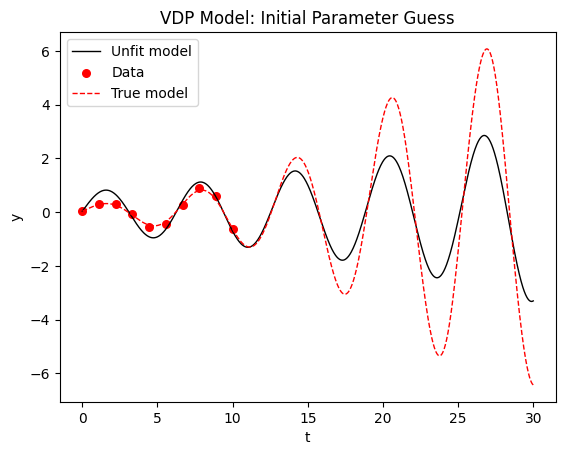

In [22]:

vdp_model = VDP(mu = 0.10) 
ts = torch.linspace(0,30.0,1000)
ts_data, y_data = data_vdp[0]

initial_conditions = y_data[0, :].unsqueeze(0)
sol_initial_guess = odeint(vdp_model, initial_conditions, ts, method='dopri5').detach().numpy()
sol_true = odeint(model_sim, initial_conditions, ts, method='dopri5').detach().numpy()

# Check the solution
plt.plot(ts, sol_initial_guess[:,:,1], color='black', lw=1.0, label='Unfit model');
plt.scatter(ts_data.detach(), y_data[:,1].detach(), color='red', s=30, label='Data');
plt.plot(ts, sol_true[:,:,1], color='red', ls='--', lw=1.0, label='True model');
plt.title("VDP Model: Initial Parameter Guess");
plt.xlabel("t");
plt.ylabel("y");
plt.legend();

Now, we will use the training loop to fit the parameters of the VDP oscillator to the simulated data. 

In [24]:

train(vdp_model, data_vdp, epochs=50)
print(f"After training: {vdp_model}, where the true value is {true_mu}")
print(f"Final Parameter Recovery Error: {vdp_model.mu - true_mu}")


Loss at 0: 0.0018198686302639544
Loss at 10: 0.0017728700768202543
Loss at 20: 0.0017710294050630182
Loss at 30: 0.0017692281980998814
Loss at 40: 0.0017697797156870365
After training:  mu: 0.29934826493263245, where the true value is 0.3
Final MSE Error: -0.0006517469882965088


Not to bad! Let's see how the plot looks now...

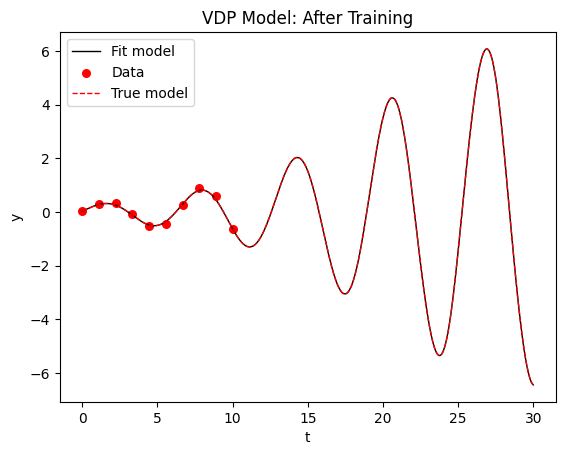

In [25]:

sol_after_fitting = odeint(vdp_model, initial_conditions, ts, method='dopri5').detach().numpy()

# Check the solution
plt.plot(ts, sol_after_fitting[:,:,1], color='black', lw=1.0, label='Fit model');
plt.scatter(ts_data.detach(), y_data[:,1].detach(), color='red', s=30, label='Data');
plt.plot(ts, sol_true[:,:,1], color='red', ls='--', lw=1.0, label='True model');
plt.title("VDP Model: After Training");
plt.xlabel("t");
plt.ylabel("y");
plt.legend();

The plot confirms that we almost perfectly recovered the parameters. One more quick plot, where we plot the dynamics of the system in the phase plane (a parametric plot of the state variables). 

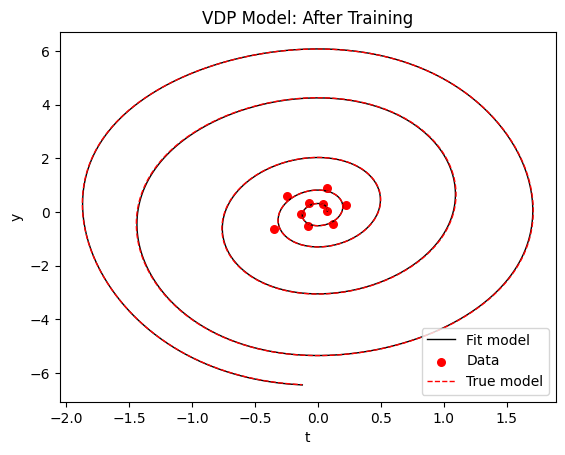

In [26]:
plt.plot(sol_after_fitting[:,:,0], sol_after_fitting[:,:,1], color='black', lw=1.0, label='Fit model');
plt.scatter(y_data[:,0], y_data[:,1].detach(), color='red', s=30, label='Data');
plt.plot(sol_true[:,:,0], sol_true[:,:,1], color='red', ls='--', lw=1.0, label='True model');
plt.title("VDP Model: After Training");
plt.xlabel("t");
plt.ylabel("y");
plt.legend();

### Lotka Voltera Equations 

Now lets adapt our methods to fit simulated data from the Lotka Voltera equations. 

In [27]:

model_sim_lv = LotkaVolterra()
ts_data = torch.linspace(0.0,10.0,10) 
data_lv = create_sim_dataset(model_sim_lv, 
                              ts = ts_data, 
                              num_samples=10, 
                              sigma_noise=0.1,
                              initial_conditions_default=torch.tensor([2.5, 2.5]))

print(model_sim_lv)

 alpha: 1.5, beta: 1.0, delta: 3.0, gamma: 1.0


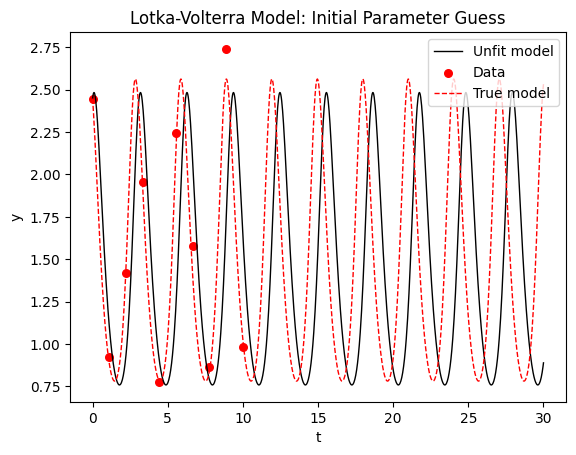

In [28]:
model_lv = LotkaVolterra(alpha=1.6, beta=1.1,delta=2.7, gamma=1.2)
ts = torch.linspace(0,30.0,1000)
ts_data, y_data = data_lv[0]

initial_conditions = y_data[0, :].unsqueeze(0)
sol_initial_guess = odeint(model_lv, initial_conditions, ts, method='dopri5').detach().numpy()
sol_true = odeint(model_sim_lv, initial_conditions, ts, method='dopri5').detach().numpy()

# Check the solution
plt.plot(ts, sol_initial_guess[:,:,1], color='black', lw=1.0, label='Unfit model');
plt.scatter(ts_data.detach(), y_data[:,1].detach(), color='red', s=30, label='Data');
plt.plot(ts, sol_true[:,:,1], color='red', ls='--', lw=1.0, label='True model');
plt.title("Lotka-Volterra Model: Initial Parameter Guess");
plt.xlabel("t");
plt.ylabel("y");
plt.legend();

In [29]:

train(model_lv, data_lv, epochs=60, lr=1e-2)
print(f"Fitted model: {model_lv}")
print(f"True model: {model_sim_lv}")

Loss at 0: 1.0979655981063843
Loss at 10: 0.1454499438405037
Loss at 20: 0.054518671706318855
Loss at 30: 0.03261260315775871
Loss at 40: 0.030149641446769238
Loss at 50: 0.0300331711769104
Fitted model:  alpha: 1.600597620010376, beta: 1.0419279336929321, delta: 2.8172996044158936, gamma: 0.9392024874687195
True model:  alpha: 1.5, beta: 1.0, delta: 3.0, gamma: 1.0


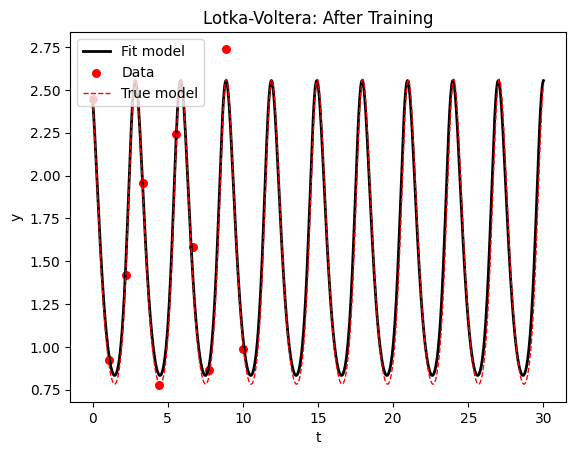

In [30]:
initial_conditions = y_data[0, :].unsqueeze(0)
sol_after_fitting = odeint(model_lv, initial_conditions, ts, method='dopri5').detach().numpy()

# Check the solution
plt.plot(ts, sol_after_fitting[:,:,1], color='black', lw=2.0, label='Fit model');
plt.scatter(ts_data, y_data[:,1], color='red', s=30, label='Data');
plt.plot(ts, sol_true[:,:,1], color='red', ls='--', lw=1.0, label='True model');
plt.title("Lotka-Voltera: After Training");
plt.xlabel("t");
plt.ylabel("y");
plt.legend();

Now let's visualize the results using a phase plane plot.

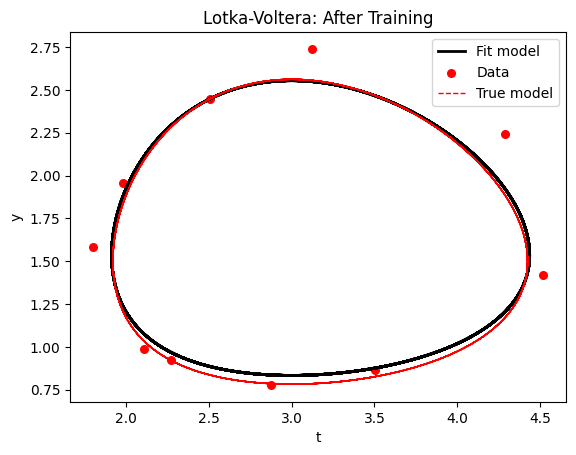

In [31]:
# Check the solution
plt.plot(sol_after_fitting[:,:,0], sol_after_fitting[:,:,1], color='black', lw=2.0, label='Fit model');
plt.scatter(y_data[:,0], y_data[:,1], color='red', s=30, label='Data');
plt.plot(sol_true[:,:,0], sol_true[:,:,1], color='red', ls='--', lw=1.0, label='True model');
plt.title("Lotka-Voltera: After Training");
plt.xlabel("t");
plt.ylabel("y");
plt.legend();

### Lorenz Equations

Finally, let's try to fit the Lorenz equations. 

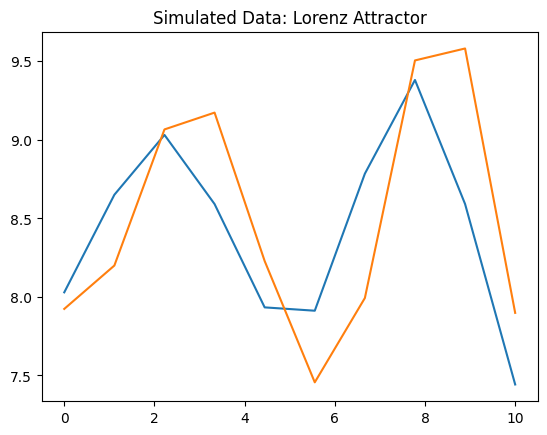

In [32]:

model_sim = Lorenz(sigma=10.0, rho=28.0, beta=8.0/3.0)
ts_data = torch.linspace(0.0,10.0,10) 
data_lorenz = create_sim_dataset(model_sim, 
                              ts = ts_data, 
                              num_samples=10, 
                              initial_conditions_default=torch.tensor([8.0, 8.0, 27.0]),
                              sigma_noise=0.01)
_, y_data = data_lorenz[0] 
plt.plot(ts_data, y_data[:,0]);
plt.plot(ts_data, y_data[:,1]);
plt.title("Simulated Data: Lorenz Attractor");

The starting point:  sigma: 11.0, rho: 23.0, beta: 1.2000000476837158


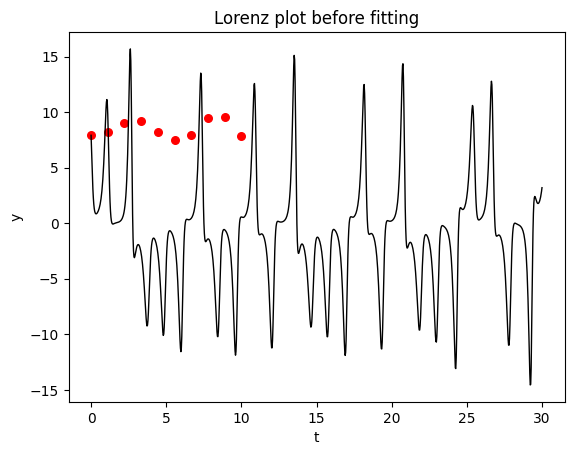

In [33]:
lorenz_model = Lorenz(sigma=11.0, rho=23.0, beta=1.2)
print(f"The starting point: {lorenz_model}")   

ts = torch.linspace(0,30.0,1000)
ts_data, y_data = data_lorenz[0]

initial_conditions = y_data[0, :].unsqueeze(0)
sol = odeint(lorenz_model, initial_conditions, ts, method='dopri5').detach().numpy()


# Check the solution
plt.plot(ts, sol[:,:,1], color='black', lw=1.0);
plt.scatter(ts_data.detach(), y_data[:,1].detach(), color='red', s=30);
plt.title("Lorenz plot before fitting");
plt.xlabel("t");
plt.ylabel("y");

In [34]:
train(lorenz_model, 
      data_lorenz, 
      epochs=10, 
      lr = 1e-3)

Loss at 0: 145.42825317382812


Let's look at the results from the fitting procedure. 

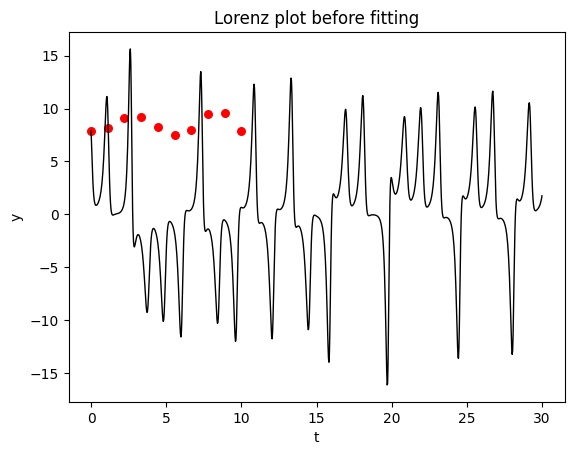

In [35]:
ts = torch.linspace(0,30.0,1000)
ts_data, y_data = data_lorenz[0]

initial_conditions = y_data[0, :].unsqueeze(0)
sol = odeint(lorenz_model, initial_conditions, ts, method='dopri5').detach().numpy()


# Check the solution
plt.plot(ts, sol[:,:,1], color='black', lw=1.0);
plt.scatter(ts_data.detach(), y_data[:,1].detach(), color='red', s=30);
plt.title("Lorenz plot before fitting");
plt.xlabel("t");
plt.ylabel("y");

In [69]:
#| hide
from nbdev.showdoc import *

In [70]:
#| hide
import nbdev; nbdev.nbdev_export()